In [4]:
using JuMP, Cbc

# Opening new Factory in Hamburg, Germany 
### Using Given Demand, we can project scooter production requirements up to the year 2032  



**Objectives** 
* Calculate required total production output per month  
* Determine production requirements of Hamburg Plant by end of year 2032
* Using Madison, WI plant's maximum production capability and storage space, determine optimal production allocations
* Assuming a Rolling Implementation, determine optimal inventory utilization 

**Constraints** 
* Madison Plant has production capacity of 2400 units per month
* Madison Plant has Finished Inventory capacity of 104000 scooters  
* Assign $2 cost per scooter in inventory to make low inventory favorable
* Cannot make changes to Madison Plant production and facility

In [1]:
#params
cost = [350.,400.,450.,600.,700.] 
init_demand = [15. 17.5 23. 20. 17. 19. 25. 18.;   #demand in 1000s
               7.5 8. 12.5 10. 7.5 10. 13. 10.; 
               7.5 8. 10. 8. 8. 8. 12. 7.5; 
               12.5 15. 19. 15. 15. 17. 20. 15.; 
               5. 7. 8. 5. 5. 6. 8. 6.] 

demand = init_demand*1000. 

Inventory_lim_Mad = 10400 

Production_lim_Mad = 2400 #per month

2400

### Demand 
Rows are SKU #'s S={1,2,3,4,5} <br>
Columns are months M = {1/31,4/31,7/31,10/31,1/32,4/32,7/32,10/32}

**Created Using Matplotlib**
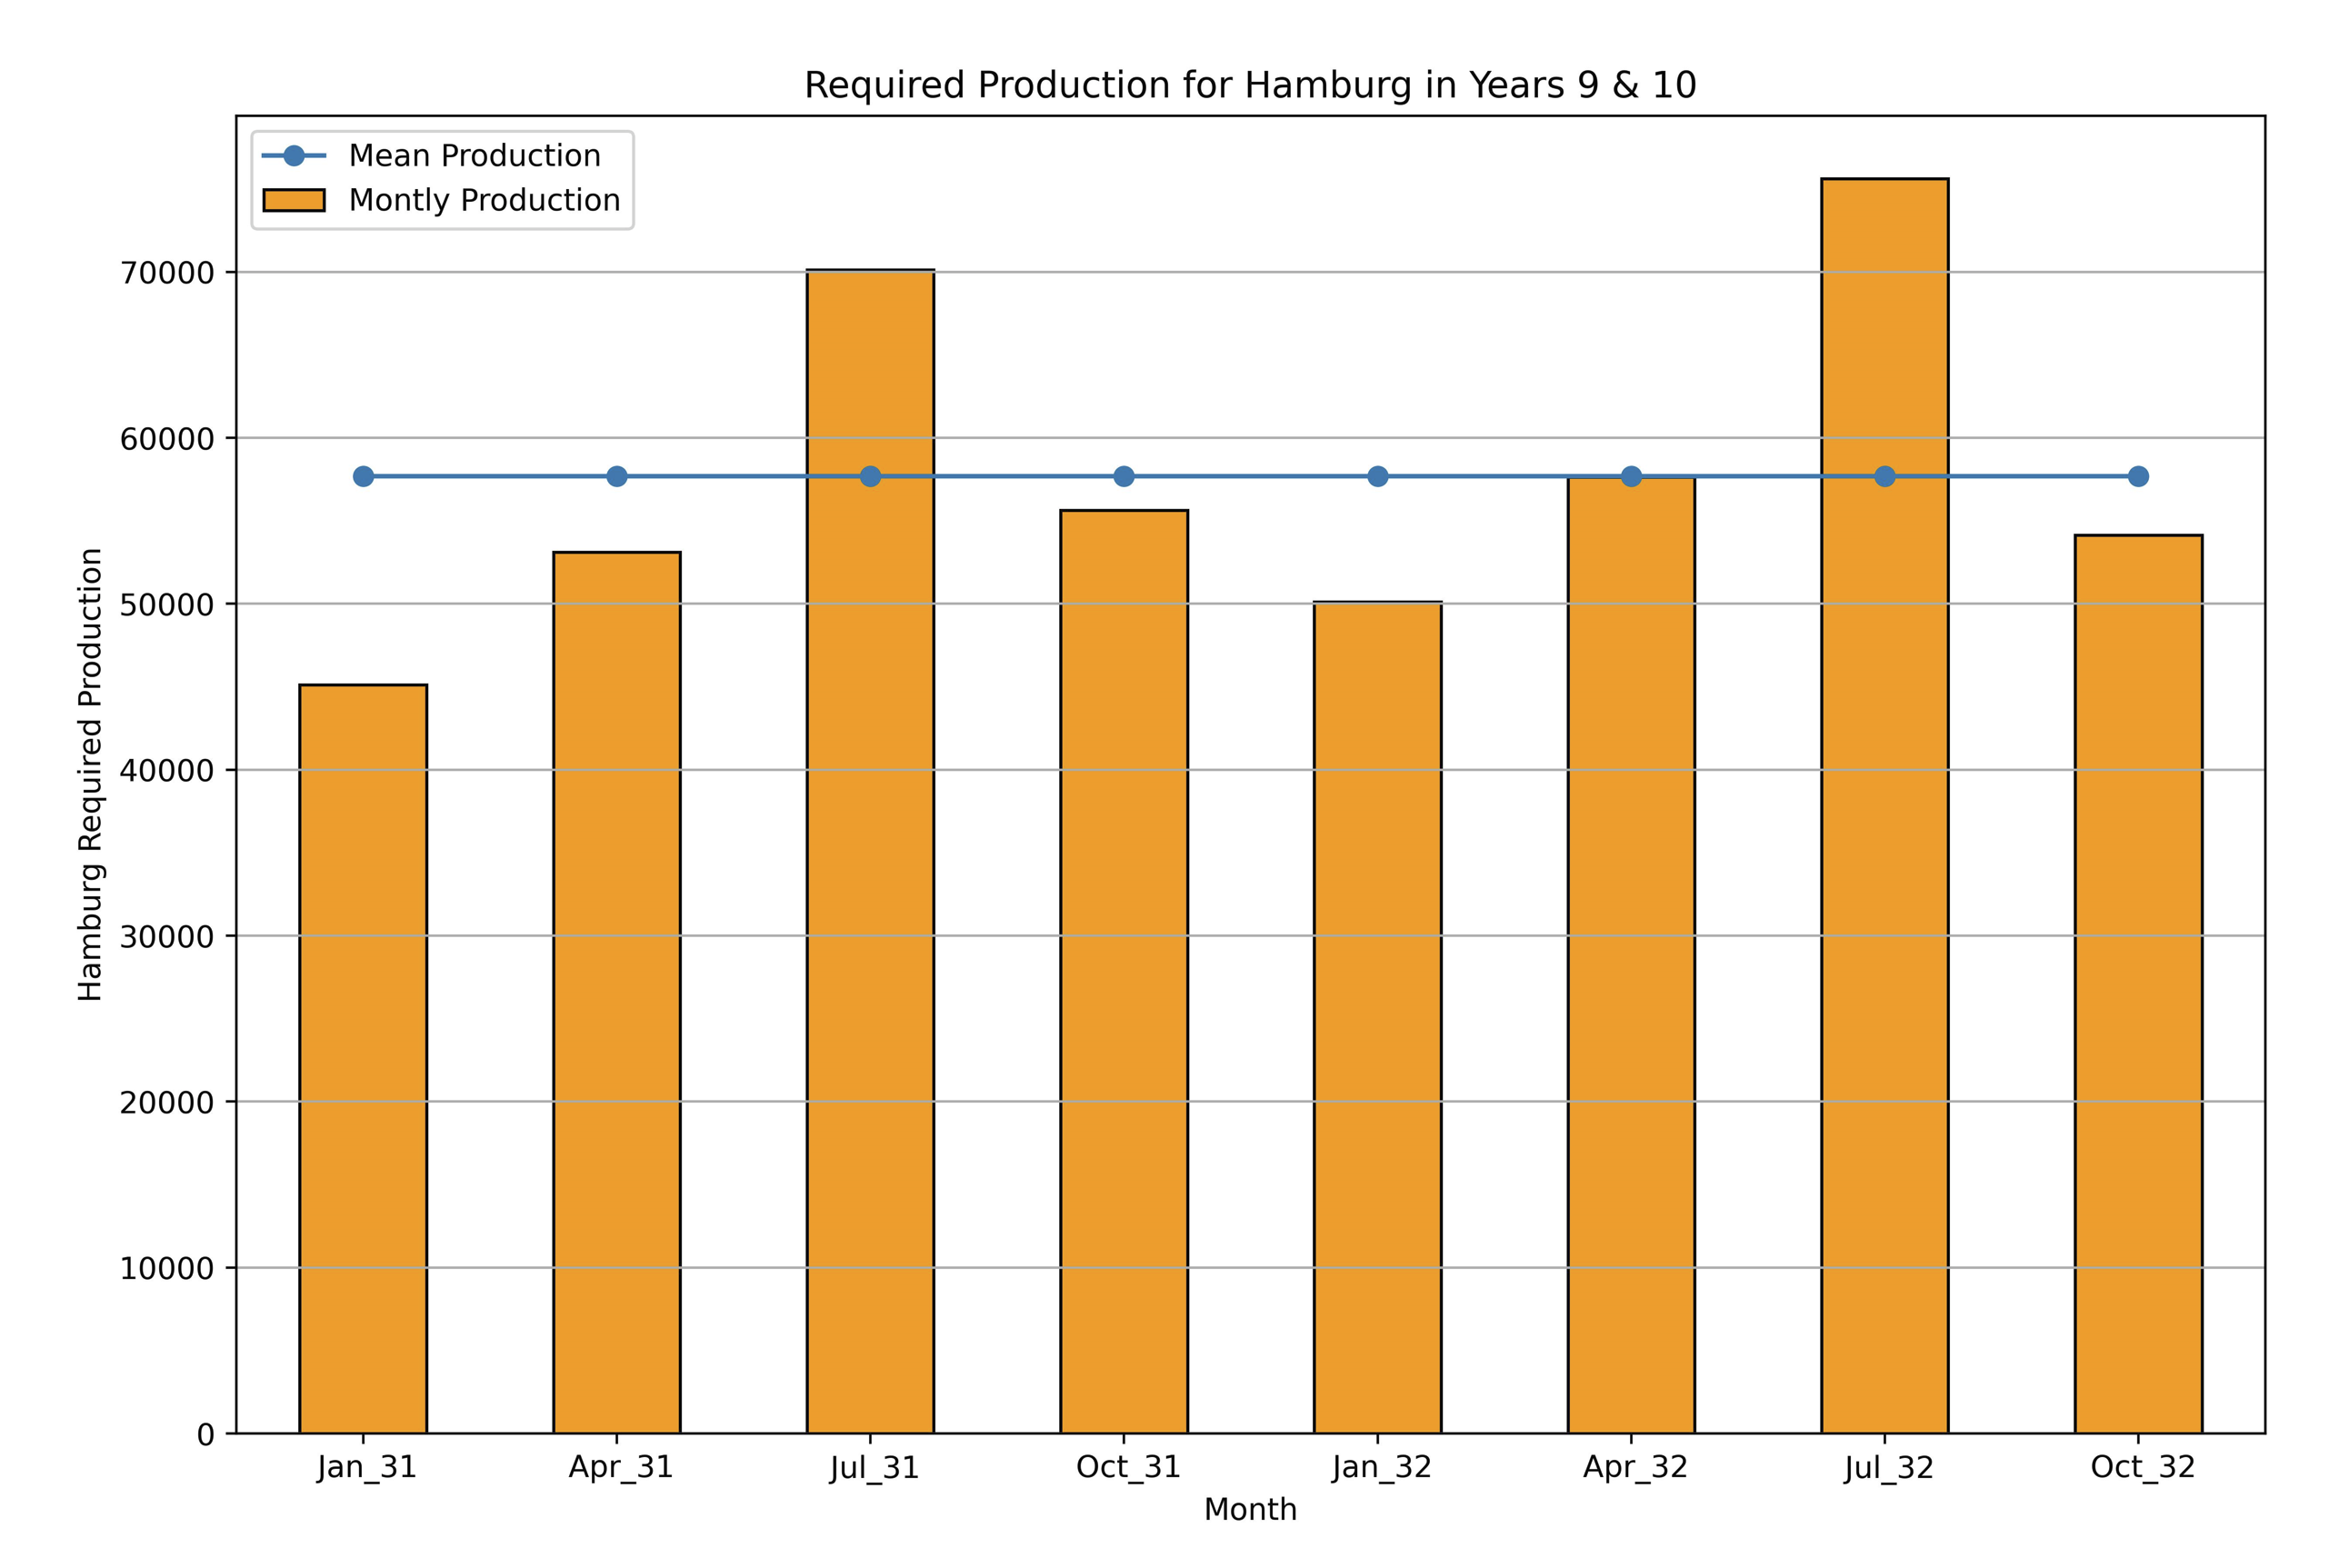 


In [2]:
n_months = 8 

#sets 
S = 1:5  #SKU numbers
M = 1:n_months #number of quarters
demand 

5×8 Matrix{Float64}:
 15000.0  17500.0  23000.0  20000.0  17000.0  19000.0  25000.0  18000.0
  7500.0   8000.0  12500.0  10000.0   7500.0  10000.0  13000.0  10000.0
  7500.0   8000.0  10000.0   8000.0   8000.0   8000.0  12000.0   7500.0
 12500.0  15000.0  19000.0  15000.0  15000.0  17000.0  20000.0  15000.0
  5000.0   7000.0   8000.0   5000.0   5000.0   6000.0   8000.0   6000.0

In [3]:
m = Model() 

n_months = 8 

#variables 
@variable(m, x[i in S, j in M] >= 0) 
@variable(m, y[i in S, j in M] >= 0) 
@variable(m, q[i in S, j in 0:n_months] >= 0) 
@variable(m, h[i in S, j in 0:n_months] >= 0) 

#objective 
@objective(m, Min, sum(cost[i]x[i,j] for i in S for j in M) + 
                   sum(cost[i]y[i,j] for i in S for j in M) - 
                   sum(2*q[i,j] for i in S for j in M) - 
                   sum(2*h[i,j] for i in S for j in M)) 

#constraints 

@constraint(m, MadInv[i in S, j in M], 
            q[i,j] + h[i,j] == q[i,j-1] + h[i,j-1] + x[i,j] + y[i,j] - demand[i,j])
@constraint(m, dems[i in S, j in M], x[i,j] + y[i,j] >= demand[i,j])
@constraint(m, initstockMad[i in S], q[i,0] == 0)
@constraint(m, initstockHam[i in S], h[i,0] == 0) 
@constraint(m, monthprodm[j in M], sum(x[i,j] for i in S) <= Production_lim_Mad) 
@constraint(m, monthinvm[j in M], sum(q[i,j] for i in S) <= Inventory_lim_Mad) 


set_optimizer(m, Cbc.Optimizer) 
optimize!(m) 

println("++++++++++++| Total Cost of years 9 and 10: \$", objective_value(m)," |++++++++++++")  
println()
println("For each value matrix, rows=SKU # (1->5) and columns = month (Jan_31->Oct_32)")
println()
println("Scooters to be produced in Madison Plant: ")
println()
println(value.(x))   
println()
println("===============================================================") 
println("Amount of scooters to be kept in inventory in Madison Plant: ") 
println()
println(value.(q))
println()
println("===============================================================")
println("===============================================================")
println("Amount of scooters to be produced in hamburg plant:") 
println()
println(value.(y))
println() 
println("===============================================================")
println("Amount of scooters to be kept in inventory in Hamburg Plant: ")  
println()
println(value.(h))
println("===============================================================")
println("===============================================================")

LoadError: UndefVarError: Model not defined

Mean production per months for two years is **57689.5**. Test to see if we can cap production to still hit demand while saving cost by utilizing storage space for lower demand months where max production for hamburg = **58000** scooters. <br> 

Since we need to produce significantly more in madison, and madison is already a job-shop/batch operation, lets produce as many personal (custom) scooters in madison as possible to allow Hamburg Plant to be more automated 

**Revisions** 
* Cap Hamburg production to end-of-forecast mean 
* Madison plant to only manufacture personal scooters (SKU 1,2,3)  
* Able to use Madison Plant storage for Hamburg Inventory Overflow 
* Initial Stock is 10400 units at each facility (Optimized model will determine which units should be stocked)

In [83]:
m = Model() 

n_months = 8 

#sets 
S = 1:5 
M = 1:n_months 

#params
cost = [350.,400.,450.,600.,700.] 
init_demand = [15. 17.5 23. 20. 17. 19. 25. 18.; 
               7.5 8. 12.5 10. 7.5 10. 13. 10.; 
               7.5 8. 10. 8. 8. 8. 12. 7.5; 
               12.5 15. 19. 15. 15. 17. 20. 15.; 
               5. 7. 8. 5. 5. 6. 8. 6.] 
demand = init_demand*1000. 

init_stock_mad = 10400 
init_stock_Ham = 10400

Inventory_lim_Mad = 10400
Inventory_lim_Ham = 10400 

Production_lim_Mad = 2400 
Production_lim_Ham = 58000

#variables 
@variable(m, x[i in S, j in M] >= 0) 
@variable(m, y[i in S, j in M] >= 0) 
@variable(m, q[i in S, j in 0:n_months] >= 0) 
@variable(m, h[i in S, j in 0:n_months] >= 0) 

#objective 
@objective(m, Min, sum(cost[i]x[i,j] for i in S for j in M) + 
                   sum(cost[i]y[i,j] for i in S for j in M) + 
                   sum(2*q[i,j] for i in S for j in M) + 
                   sum(2*h[i,j] for i in S for j in M)) 

#constraints 

#Inventory Rolling Implementation
@constraint(m, MadInv[i in S, j in M], 
            h[i,j] + q[i,j] == h[i,j-1] + q[i,j-1] + x[i,j] + y[i,j] - demand[i,j])

#initial Stock
#@constraint(m, initstockMad[i in S], q[i,0] == 0)
#@constraint(m, initstockHam[i in S], h[i,0] == 0) 
@constraint(m, initstockMad, sum(q[i,0] for i in S) <= 10400)
@constraint(m, initstockHam, sum(h[i,0] for i in S) <= 10400)

#production 
@constraint(m, monthprodm[j in M], sum(x[i,j] for i in S) <= Production_lim_Mad)
@constraint(m, monthprodh[j in M], sum(y[i,j] for i in S) <= Production_lim_Ham)

#inventory
@constraint(m, monthinvm[j in M], sum(q[i,j] for i in S) <= Inventory_lim_Mad) 
@constraint(m, monthinvh[j in M], sum(h[i,j] for i in S) <= Inventory_lim_Ham)

#Mad production only SKU 1,2,3
@constraint(m,MadProd4[j in M], x[4,j] == 0)
@constraint(m,MadProd5[j in M], x[5,j] == 0) 



set_optimizer(m, Cbc.Optimizer) 
optimize!(m) 


println("++++++++++++| Total Cost of years 9 and 10: \$", objective_value(m)," |++++++++++++")  
println()
println("For each value matrix, rows=SKU # (1->5) and columns = month (Jan_31->Oct_32)")
println()
println("Scooters to be produced in Madison Plant: ")
println()
println(value.(x))   
println()
println("===============================================================") 
println("Amount of scooters to be kept in inventory in Madison Plant: ") 
println()
println(value.(q))
println()
println("===============================================================")
println("===============================================================")
println("Amount of scooters to be produced in hamburg plant:") 
println()
println(value.(y))
println() 
println("===============================================================")
println("Amount of scooters to be kept in inventory in Hamburg Plant: ")  
println()
println(value.(h))
println("===============================================================")
println("===============================================================")

++++++++++++| Total Cost of years 9 and 10: $2.142366e8 |++++++++++++

For each value matrix, rows=SKU # (1->5) and columns = month (Jan_31->Oct_32)

Scooters to be produced in Madison Plant: 

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:5
    Dimension 2, 1:8
And data, a 5×8 Matrix{Float64}:
    0.0  2400.0     0.0     0.0  2400.0     0.0     0.0  2400.0
 2400.0     0.0     0.0     0.0     0.0     0.0  2400.0     0.0
    0.0     0.0  2400.0  2400.0     0.0  2400.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0

Amount of scooters to be kept in inventory in Madison Plant: 

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:5
    Dimension 2, 0:8
And data, a 5×9 Matrix{Float64}:
     0.0      0.0     0.0    0.0  9300.0     0.0      0.0  0.0  0.0
     0.0      0.0     0.0    0.0     0.0     0.0      0.0  0.0  0.0
     0.0      

# Data Based on Optimization Model Output

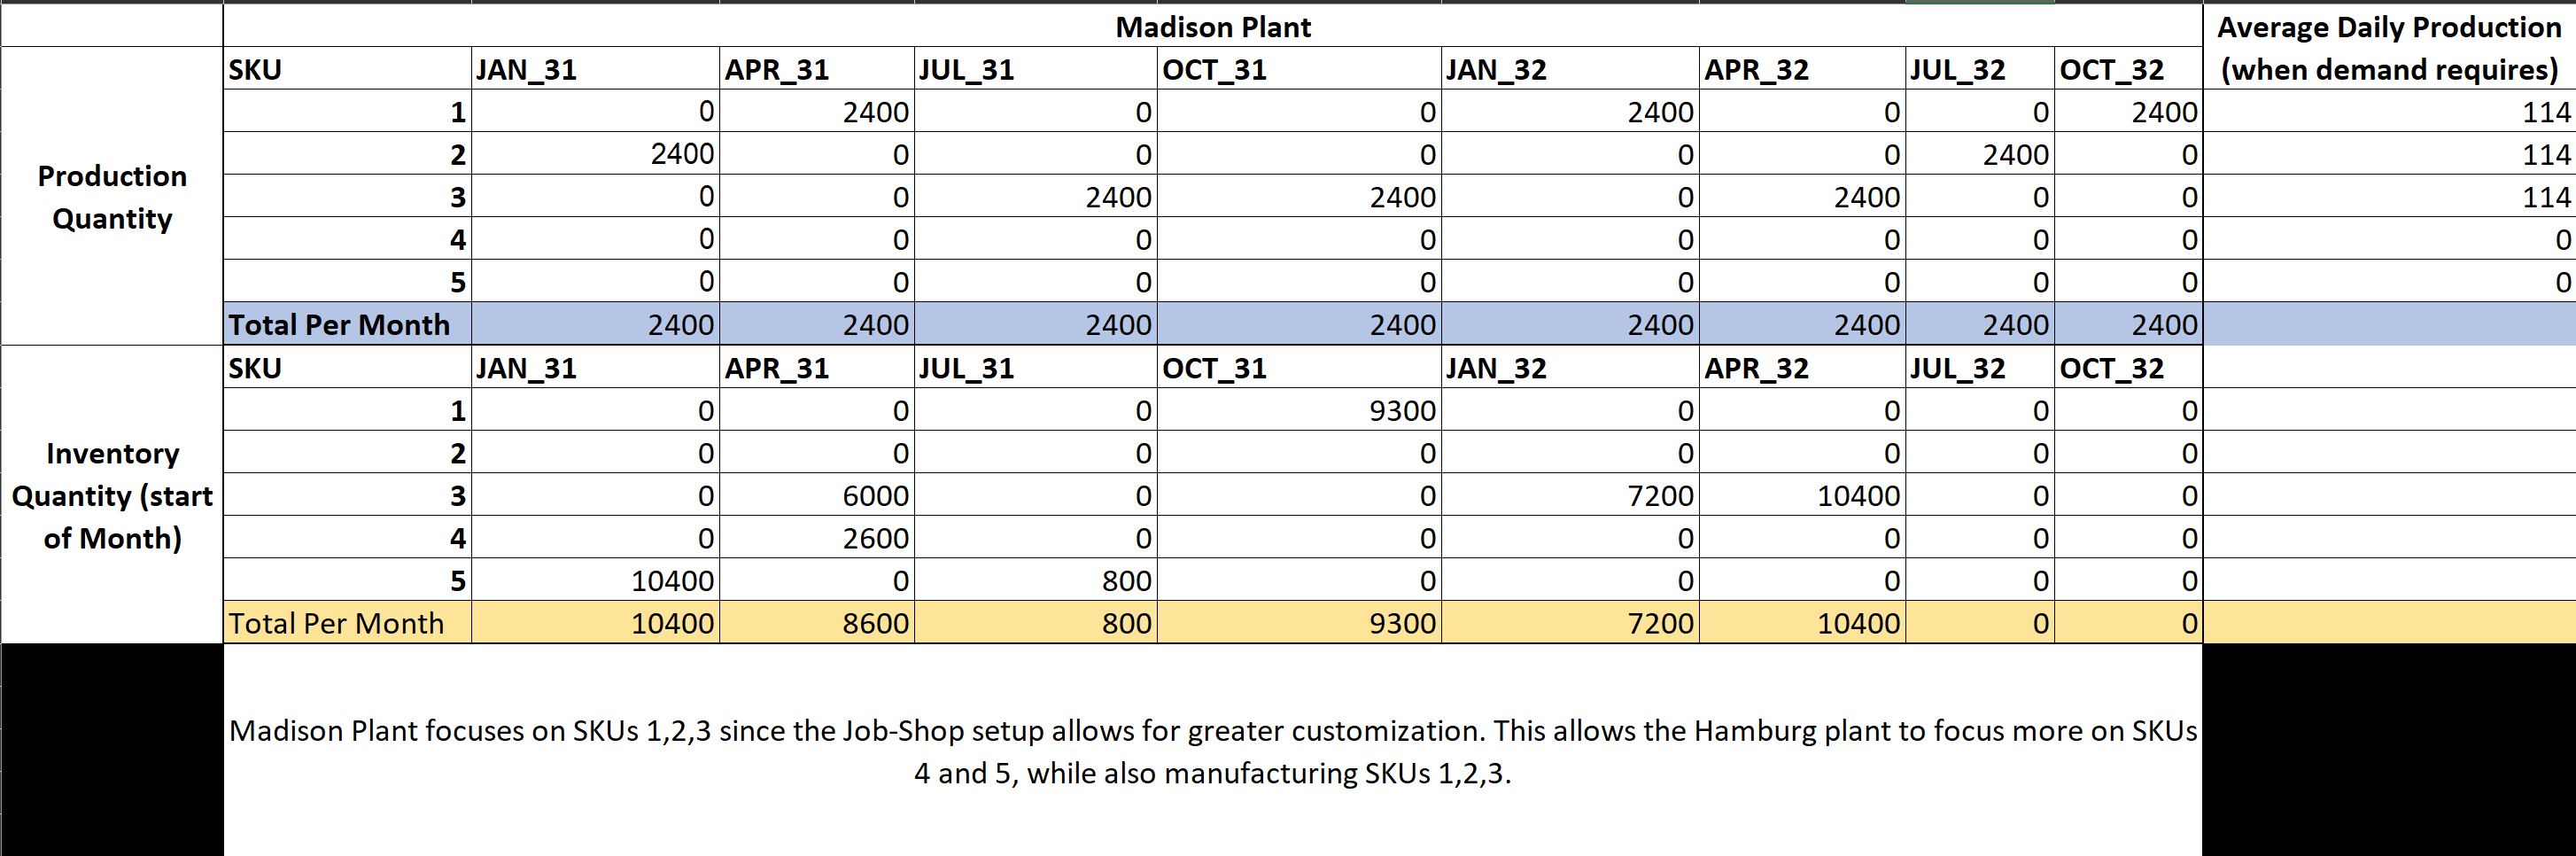

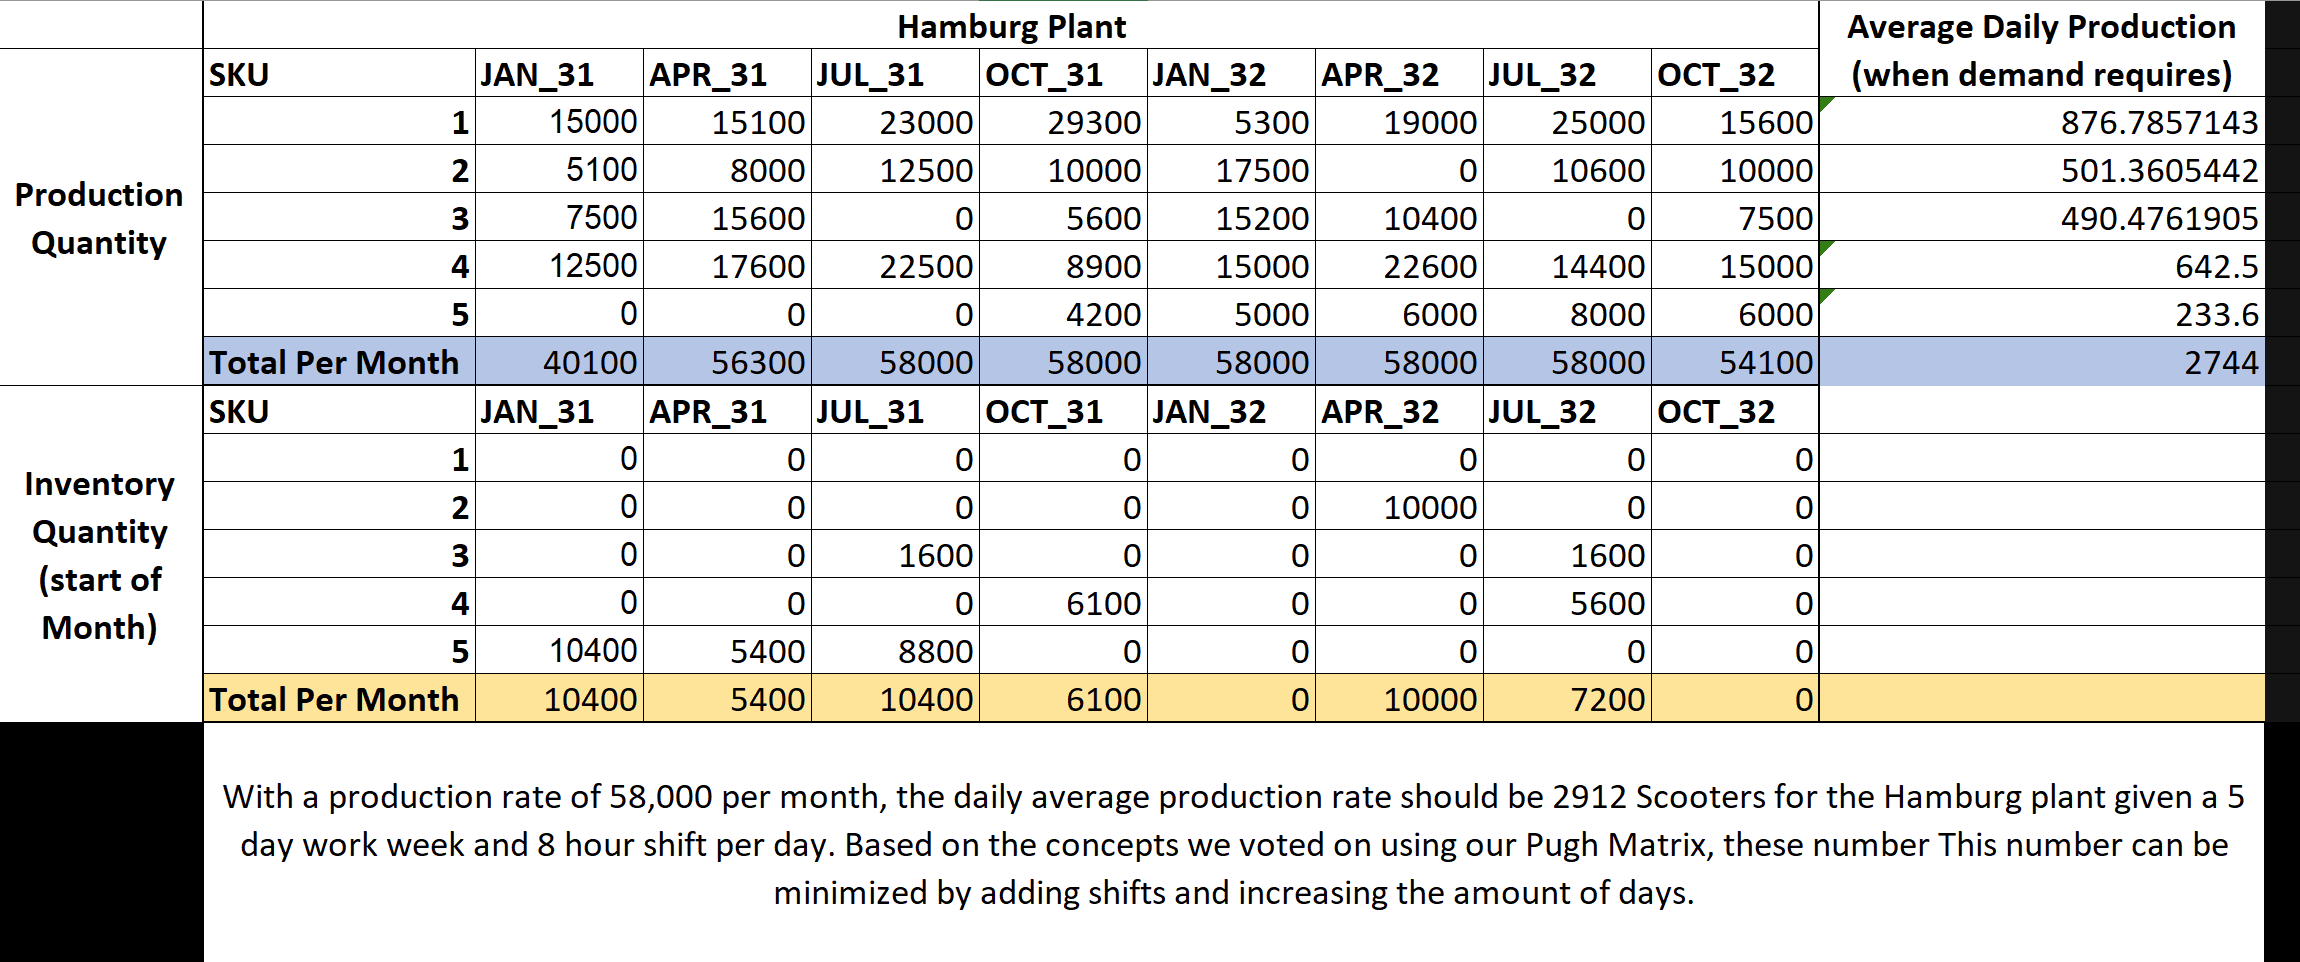

# Increasing Output

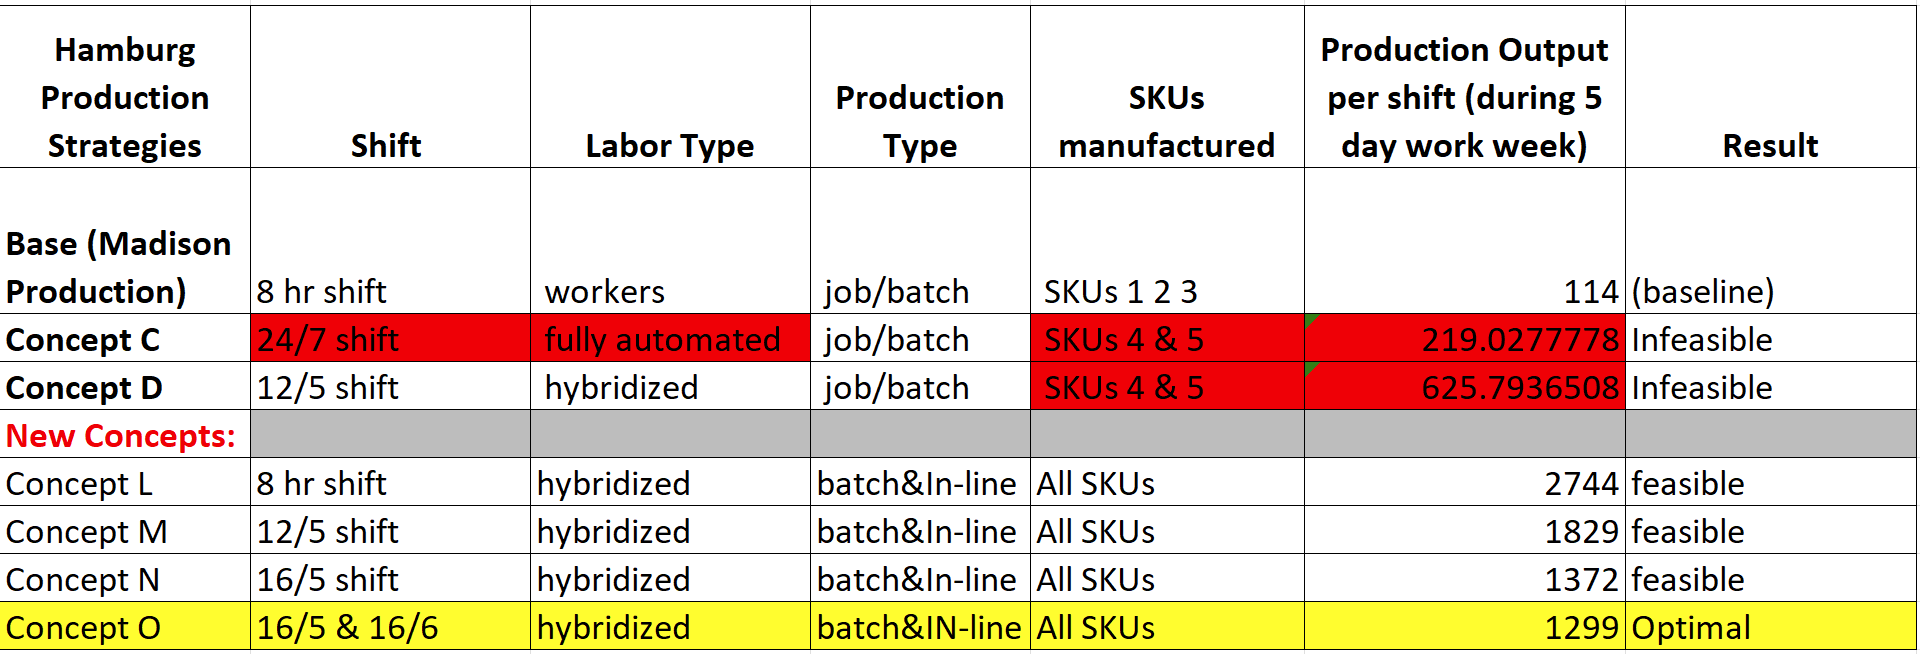

# Optimal Decision 
In order to meet demand by 2032, the Hamburg Plant should work to implement **two 8-hour shifts**.
**SKUs 4 & 5:** 
* Production is fully automated 
* two 8-hour shifts Monday-Saturday for supervisors

**SKUs 1, 2, and 3** 
* Production include a certain degree of automation with workers for customization 
* two 8-hour shifts monday-friday for manufacturers and assemblers 